C:\Users\venka\AppData\Local\Temp\ipykernel_13660\1170995500.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\venka\AppData\Local\Temp\ipykernel_13660\1170995500.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Accuracy: 80.45%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



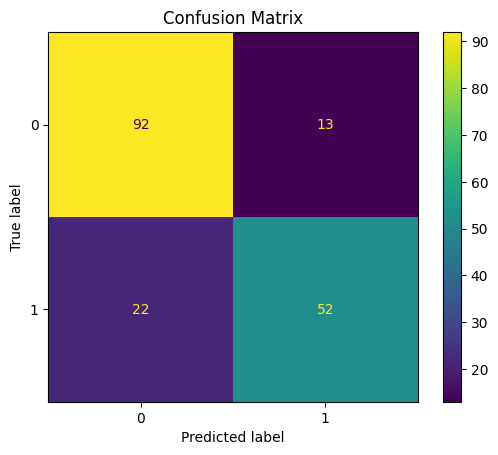

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv('Titanic.csv')

# df= pd.read_excel()
# Preprocess Data
# Drop unnecessary columns
df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

# Handle missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Encode categorical variables
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Split the data into features and target
X = df.drop(columns=['Survived']).values
y = df['Survived'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Stump (Weak Classifier)
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None
    
    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X[:, self.feature_index] < self.threshold] = -1
        else:
            predictions[X[:, self.feature_index] >= self.threshold] = -1
        return predictions

# AdaBoost Algorithm from Scratch
class AdaBoost:
    def __init__(self, n_clf=50):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights
        w = np.full(n_samples, (1 / n_samples))
        # mp.full(n_samples,())
        y = np.where(y == 0, -1, 1)  # Convert 0 to -1 for AdaBoost
        
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float('inf')
            
            # Find the best decision stump
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                
                for threshold in unique_values:
                    for polarity in [1, -1]:
                        stump = DecisionStump()
                        stump.feature_index = feature_i
                        stump.threshold = threshold
                        stump.polarity = polarity
                        predictions = stump.predict(X)
                        
                        # Calculate weighted error
                        error = sum(w * (predictions != y))
                        
                        # Choose the best stump
                        if error < min_error:
                            min_error = error
                            clf.feature_index = feature_i
                            clf.threshold = threshold
                            clf.polarity = polarity
            
            # Calculate alpha
            clf.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))
            
            # Update weights
            predictions = clf.predict(X)
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)
            
            # Save the current classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        return np.sign(y_pred)

# Train AdaBoost model
model = AdaBoost(n_clf=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.where(y_pred == -1, 0, 1)  # Convert -1 back to 0

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix')
plt.show()
